# Modelos usando el algoritmo de Naive Bayes

### Importación de bibliotecas

In [1]:
import pandas as pd
import numpy as np
import preprocessing
import informe

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV

from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, auc

from matplotlib import pyplot as plt

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

### Llamado a funciones de preprocesamiento

In [3]:
df = preprocessing.remove_irrelevant_features(df)
df = preprocessing.missings_treatment(df)
df = preprocessing.one_hot_encoding(df)
X = df.drop('tiene_alto_valor_adquisitivo', axis='columns')

y = df.tiene_alto_valor_adquisitivo
X_train, X_val, y_train, y_val = preprocessing.dataset_split(X, y)

X_val, X_holdout, y_val, y_holdout = preprocessing.dataset_split(X_val, y_val, 0.2)

### Seteo de conjuntos de hiperparametros por los que se iterará en la busqueda de la mejor combinación

In [4]:
smoothing = np.array([1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05,1e-04, 1e-03, 1e-02, 1e-01, 1])

### Modelos

#### Modelo 1
- se tratan todos los features como continuos

In [5]:
modelo1 = GaussianNB()

params = {'var_smoothing': smoothing}

rscv = RandomizedSearchCV(
    modelo1, params, n_iter=11, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

informe.imprimir_metricas(rscv, X_val, y_val, nombre = "modelo 1")

modelo1 = rscv.best_estimator_

Resultados modelo 1
    Mejores hiperparámetros: {'var_smoothing': 1e-08}
    Métrica AUC ROC: 0.89
    Otras metricas:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      5933
           1       0.76      0.31      0.44      1882

    accuracy                           0.81      7815
   macro avg       0.79      0.64      0.66      7815
weighted avg       0.80      0.81      0.78      7815



#### Modelo 2
- se tratan todos los features como discretos 
- se descarta el feature ganancia_perdida_declarada_bolsa_argentina ya que toma demasiados valores y ademas tiene valores negativos que no son válidos para el algoritmo

In [6]:
X_train_m = X_train.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')
X_val_m = X_val.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')
X_holdout_m = X_holdout.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')

In [7]:
modelo2 = MultinomialNB()

params = {'alpha': smoothing}

rscv = RandomizedSearchCV(
    modelo2, params, n_iter=11, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train_m, y_train)

informe.imprimir_metricas(rscv, X_val_m, y_val, nombre = "modelo 2")

modelo2 = rscv.best_estimator_

Resultados modelo 2
    Mejores hiperparámetros: {'alpha': 0.01}
    Métrica AUC ROC: 0.84
    Otras metricas:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      5933
           1       0.49      0.73      0.59      1882

    accuracy                           0.75      7815
   macro avg       0.69      0.74      0.70      7815
weighted avg       0.80      0.75      0.77      7815



#### Modelo 3
- se usa una combinación de naive bayes multinomial y gaussiano
- primero se debe construir una clase estimador siguiendo las reglas de sklearn por cuestiones de compatibilidad

In [8]:
class Modelo3(BaseEstimator, ClassifierMixin):
    def __init__(self, var_smoothing=1e-09, alpha=1): 
        self.var_smoothing = var_smoothing 
        self.alpha = alpha
        
    def fit(self, X_train, y_train):

        self._gnb = GaussianNB(var_smoothing = self.var_smoothing)
        self._mnb = MultinomialNB(alpha=self.alpha)
        
        X_train_g = X_train[['ganancia_perdida_declarada_bolsa_argentina']]
        X_train_m = X_train.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')

        self._gnb.fit(X_train_g, y_train)
        self._mnb.fit(X_train_m, y_train)

        X_train_proba_g = pd.DataFrame(self._gnb.predict_proba(X_train_g)).drop(0, axis='columns')
        X_train_proba_m = pd.DataFrame(self._mnb.predict_proba(X_train_m)).drop(0, axis='columns')

        # se construye el dataframe de probabilidades con los datos de entrenamiento
        X_train_proba = pd.DataFrame()
        X_train_proba['1_gaussian'] = X_train_proba_g[1]
        X_train_proba['1_multinomial'] = X_train_proba_m[1]

        # se aplica naive bayes gaussiano al dataframe de probabilidades
        self._gnb_proba = GaussianNB().fit(X_train_proba, y_train)
        return self

    def predict(self, X_pred):
        X_pred_proba = self._construir_instancias_de_probabilidades(X_pred)
        return self._gnb_proba.predict(X_pred_proba)
    
    def predict_proba(self, X_pred):
        X_pred_proba = self._construir_instancias_de_probabilidades(X_pred)
        return self._gnb_proba.predict_proba(X_pred_proba)

    def _construir_instancias_de_probabilidades(self, X_pred):
        X_pred_g = X_pred[['ganancia_perdida_declarada_bolsa_argentina']]
        X_pred_m = X_pred.drop('ganancia_perdida_declarada_bolsa_argentina', axis='columns')

        # se aplica el modelo compuesto a los datos de validación y se obtiene la predicción
        X_pred_proba_g = pd.DataFrame(self._gnb.predict_proba(X_pred_g)).drop(0, axis='columns')
        X_pred_proba_m = pd.DataFrame(self._mnb.predict_proba(X_pred_m)).drop(0, axis='columns')
        X_pred_proba = pd.DataFrame()
        X_pred_proba['1_gaussian'] = X_pred_proba_g[1]
        X_pred_proba['1_multinomial'] = X_pred_proba_m[1]
        return X_pred_proba

In [9]:
modelo3 = Modelo3()

params = {'var_smoothing': smoothing, 'alpha': smoothing}

rscv = RandomizedSearchCV(
    modelo3, params, n_iter=60, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

informe.imprimir_metricas(rscv, X_val, y_val, nombre = "modelo 3")

modelo3 = rscv.best_estimator_

Resultados modelo 3
    Mejores hiperparámetros: {'var_smoothing': 1.0, 'alpha': 0.1}
    Métrica AUC ROC: 0.87
    Otras metricas:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      5933
           1       0.98      0.18      0.30      1882

    accuracy                           0.80      7815
   macro avg       0.89      0.59      0.59      7815
weighted avg       0.84      0.80      0.74      7815



### Conclusión
      En base a la metrica AUC-ROC se elige el modelo 1
      
### Informe del modelo 1 usando los datos del test_holdout

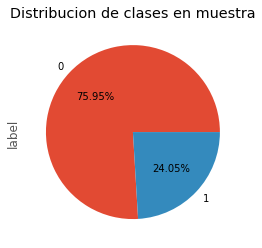

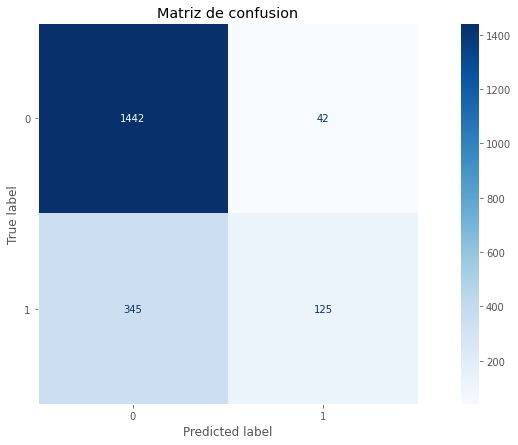

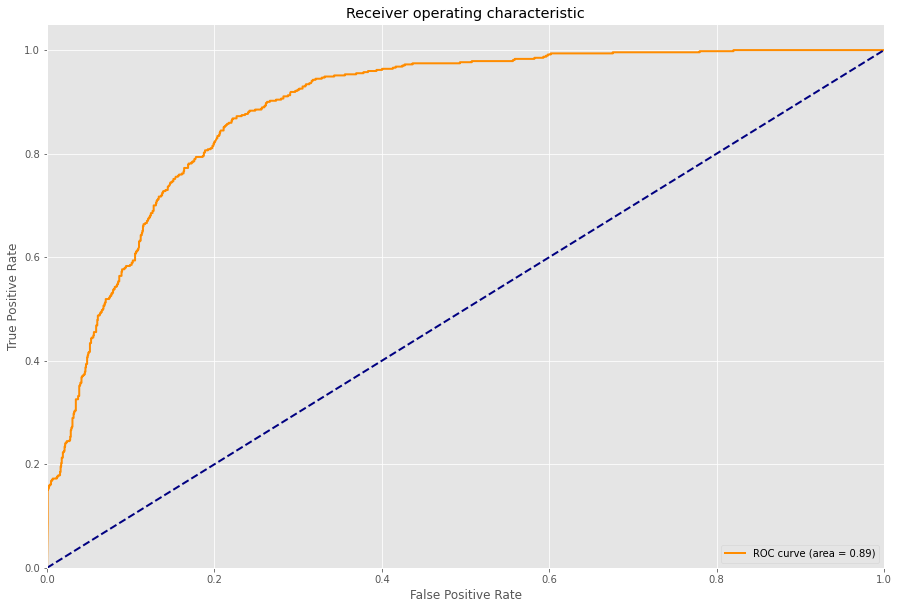

Métricas:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1484
           1       0.75      0.27      0.39       470

    accuracy                           0.80      1954
   macro avg       0.78      0.62      0.64      1954
weighted avg       0.79      0.80      0.76      1954



In [10]:
informe.imprimir_informe(modelo1, X_holdout, y_holdout)

### Conclusiones de las métricas observadas de los datos de hold_out

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 80%, viendo la distribucion de clases de la muestra se observa que el 0 es la clase mayoritaria con una proporción de aproximadamente 76%. Por lo tanto el modelo es mejor predictor que devolver siempre cero.
    
    
- precisión:

        El porcentaje de predicciones de bajos ingresos que realmente lo eran fue de aproximadamente 81% y el de predicciones de altos ingresos que realmente lo eran fue del 75% 


- recall:

        Los bajos ingresos reales detectados fueron aproximadamente del 97%, y los altos ingresos reales detectados fueron del 30%. Viendo este resultado en conjunto con la precisión, se entiende que el modelo es bueno detectando a los encuestados de bajos ingresos pero confunde al 70% de los altos ingresos como de bajos ingresos.


- matriz de confusion:

        Aquí tambien se puede ver que la mayoria de predicciones de bajos ingresos son correctas, pero gran parte de los altos ingresos reales no fueron bien predichos.
        También que aproximadamente el 80% de las instancias se encuentran en la diagonal principal, (lo cual ya sabiamos ya que el accuracy era del 80%).
        
        
- AUC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases con un score de 0.89. Este valor será utilizado para decidir sobre la elección de este modelo.


# Final test

In [11]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.remove_irrelevant_features(df_test)
df_test = preprocessing.missings_treatment(df_test)
df_test = preprocessing.one_hot_encoding(df_test)

y_pred = modelo1.predict(df_test)
informe.save_pred(y_pred, 'nb')